In [7]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [18]:
# Load the CT volume and infection mask
ct_volume = nib.load(r'C:\Users\BAPS\Documents\Dicom Analaysis\Dicom_Analyzer\Slice_Classifier\Dataset\Covid_Dataset\ct_scans\coronacases_org_001.nii').get_fdata()          # Shape: (512, 512, num_slices)
infection_mask = nib.load(r'C:\Users\BAPS\Documents\Dicom Analaysis\Dicom_Analyzer\Slice_Classifier\Dataset\Covid_Dataset\infection_mask\coronacases_001.nii').get_fdata()  # Same shape as ct_volume


# Verify shapes match
assert ct_volume.shape == infection_mask.shape, "CT and mask shapes do not match!"

In [19]:
# Identify slices with infections (1) vs. normal (0)
abnormal_slices = []
for slice_idx in range(infection_mask.shape[2]):
    if np.any(infection_mask[:, :, slice_idx]):
        abnormal_slices.append(1)
    else:
        abnormal_slices.append(0)

# Create DataFrame
df = pd.DataFrame({
    'slice_number': list(range(infection_mask.shape[2])),  # 0-based index
    'label': abnormal_slices
})

print(f"Total slices: {len(df)}")
print(f"Abnormal slices: {df['label'].sum()} ({(df['label'].sum()/len(df))*100:.2f}%)")

Total slices: 301
Abnormal slices: 161 (53.49%)


In [20]:
# Split into train/test (stratify to preserve class balance)
X = df['slice_number'].values  # Slice indices (0-based)
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # Critical for imbalanced data
    random_state=42
)

print(f"Train slices: {len(X_train)}")
print(f"Test slices: {len(X_test)}")

Train slices: 240
Test slices: 61


In [21]:
class CTDataset(Dataset):
    def __init__(self, slice_indices, labels, ct_volume):
        self.slice_indices = slice_indices
        self.labels = labels
        self.ct_volume = ct_volume

    def __len__(self):
        return len(self.slice_indices)

    def __getitem__(self, idx):
        slice_idx = self.slice_indices[idx]
        # Extract and normalize the CT slice
        ct_slice = self.ct_volume[:, :, slice_idx].astype(np.float32)
        ct_slice = (ct_slice - np.min(ct_slice)) / (np.max(ct_slice) - np.min(ct_slice))  # Normalize to [0, 1]
        # Convert to tensor and add channel dimension (1 channel for grayscale)
        ct_slice = torch.tensor(ct_slice).unsqueeze(0)  # Shape: [1, 512, 512]
        label = torch.tensor(self.labels[idx]).float()  # Binary label
        return ct_slice, label

# Create datasets and dataloaders
train_dataset = CTDataset(X_train, y_train, ct_volume)
test_dataset = CTDataset(X_test, y_test, ct_volume)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

class SliceClassifier(nn.Module):
    def __init__(self, dropout=0.2):
        super().__init__()
        self.model = nn.Sequential(
            # Input: [1, 512, 512]
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # [32, 512, 512]
            nn.ReLU(),
            nn.MaxPool2d(2),                              # [32, 256, 256]
            nn.Dropout2d(p=dropout),                       # Dropout for conv features
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # [64, 256, 256]
            nn.ReLU(),
            nn.MaxPool2d(2),                              # [64, 128, 128]
            nn.Dropout2d(p=dropout),                       # More dropout
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # [128, 128, 128]
            nn.ReLU(),
            nn.MaxPool2d(2),                              # [128, 64, 64]
            nn.Dropout2d(p=dropout),                       # And even more dropout
            
            nn.Flatten(),                                 # Flatten for the FC layers
            nn.Linear(128 * 64 * 64, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout),                         # Dropout before final classification
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Device setup: use GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SliceClassifier(dropout=0.2).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Make sure these are defined before running this code:
# - model (e.g., an instance of SliceClassifier with dropout=0.2)
# - criterion (e.g., nn.BCELoss())
# - train_loader (DataLoader for training dataset)
# - val_loader (DataLoader for validation/test dataset)

# Device setup: use GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Hyperparameters
num_epochs = 50
learning_rate = 1e-4
patience = 5  # Early stopping patience

# Optimizer and Learning Rate Scheduler (without verbose)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(1, num_epochs + 1):
    # ----- Training Phase -----
    model.train()
    running_train_loss = 0.0
    train_samples = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]", leave=False)
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()  # Expected shape: [batch_size]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = inputs.size(0)
        running_train_loss += loss.item() * batch_size
        train_samples += batch_size
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_train_loss / train_samples

    # ----- Validation Phase -----
    model.eval()
    running_val_loss = 0.0
    val_samples = 0
    all_preds = []
    all_labels = []

    val_bar = tqdm(test_loader, desc=f"Epoch {epoch}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            batch_size = inputs.size(0)
            running_val_loss += loss.item() * batch_size
            val_samples += batch_size

            # Apply threshold for binary classification
            preds = (outputs > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy().astype(int))
            val_bar.set_postfix(loss=loss.item())

    avg_val_loss = running_val_loss / val_samples
    accuracy = accuracy_score(all_labels, all_preds)

    # Step the scheduler using the average validation loss
    scheduler.step(avg_val_loss)
    # Get the current learning rate from the scheduler
    current_lr = scheduler.get_last_lr()[0]

    print(f"Epoch {epoch}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {accuracy:.4f} | LR: {current_lr:.6f}")

    # ----- Checkpoint Saving & Early Stopping -----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0

        # Save a complete checkpoint for later use
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_val_loss,
            'early_stopping_counter': early_stopping_counter,
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
        }
        torch.save(checkpoint, "best_checkpoint.pth")
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

print("Training complete.")


Epoch 1/50 | Train Loss: 0.6022 | Val Loss: 0.4935 | Val Acc: 0.6230 | LR: 0.000100


Epoch 2/50 | Train Loss: 0.4214 | Val Loss: 0.2311 | Val Acc: 0.9508 | LR: 0.000100


Epoch 3/50 | Train Loss: 0.2238 | Val Loss: 0.1197 | Val Acc: 0.9508 | LR: 0.000100


Epoch 4/50 | Train Loss: 0.1320 | Val Loss: 0.0590 | Val Acc: 0.9836 | LR: 0.000100


Epoch 5/50 | Train Loss: 0.1360 | Val Loss: 0.0552 | Val Acc: 0.9836 | LR: 0.000100


Epoch 6/50 | Train Loss: 0.1182 | Val Loss: 0.1143 | Val Acc: 0.9508 | LR: 0.000100


Epoch 7/50 | Train Loss: 0.1090 | Val Loss: 0.0475 | Val Acc: 0.9836 | LR: 0.000100


Epoch 8/50 | Train Loss: 0.0915 | Val Loss: 0.0334 | Val Acc: 0.9836 | LR: 0.000100


Epoch 9/50 | Train Loss: 0.0597 | Val Loss: 0.0226 | Val Acc: 0.9836 | LR: 0.000100


Epoch 10/50 | Train Loss: 0.0978 | Val Loss: 0.0363 | Val Acc: 0.9836 | LR: 0.000100


Epoch 11/50 | Train Loss: 0.0848 | Val Loss: 0.0939 | Val Acc: 0.9672 | LR: 0.000100


Epoch 12/50 | Train Loss: 0.1050 | Val Loss: 0.0419 | Val Acc: 0.9836 | LR: 0.000100


Epoch 13/50 | Train Loss: 0.0630 | Val Loss: 0.0206 | Val Acc: 0.9836 | LR: 0.000100


Epoch 14/50 | Train Loss: 0.0643 | Val Loss: 0.0475 | Val Acc: 0.9836 | LR: 0.000100


Epoch 15/50 | Train Loss: 0.0847 | Val Loss: 0.0538 | Val Acc: 0.9836 | LR: 0.000100


Epoch 16/50 | Train Loss: 0.0902 | Val Loss: 0.0286 | Val Acc: 1.0000 | LR: 0.000100


Epoch 17/50 | Train Loss: 0.0435 | Val Loss: 0.0265 | Val Acc: 0.9836 | LR: 0.000050


Epoch 18/50 | Train Loss: 0.0458 | Val Loss: 0.0166 | Val Acc: 1.0000 | LR: 0.000050


Epoch 19/50 | Train Loss: 0.0353 | Val Loss: 0.0172 | Val Acc: 0.9836 | LR: 0.000050


Epoch 20/50 | Train Loss: 0.0328 | Val Loss: 0.0131 | Val Acc: 1.0000 | LR: 0.000050


Epoch 21/50 | Train Loss: 0.0403 | Val Loss: 0.0187 | Val Acc: 0.9836 | LR: 0.000050


Epoch 22/50 | Train Loss: 0.0470 | Val Loss: 0.0152 | Val Acc: 0.9836 | LR: 0.000050


Epoch 23/50 | Train Loss: 0.0290 | Val Loss: 0.0129 | Val Acc: 1.0000 | LR: 0.000050


Epoch 24/50 | Train Loss: 0.0280 | Val Loss: 0.0170 | Val Acc: 0.9836 | LR: 0.000050


Epoch 25/50 | Train Loss: 0.0411 | Val Loss: 0.0135 | Val Acc: 1.0000 | LR: 0.000050


Epoch 26/50 | Train Loss: 0.0229 | Val Loss: 0.0141 | Val Acc: 0.9836 | LR: 0.000050


Epoch 27/50 | Train Loss: 0.0393 | Val Loss: 0.0099 | Val Acc: 1.0000 | LR: 0.000050


Epoch 28/50 | Train Loss: 0.0423 | Val Loss: 0.0303 | Val Acc: 0.9836 | LR: 0.000050


Epoch 29/50 | Train Loss: 0.0450 | Val Loss: 0.0150 | Val Acc: 0.9836 | LR: 0.000050


Epoch 30/50 | Train Loss: 0.0363 | Val Loss: 0.0169 | Val Acc: 0.9836 | LR: 0.000050


Epoch 31/50 | Train Loss: 0.0294 | Val Loss: 0.0095 | Val Acc: 1.0000 | LR: 0.000050


Epoch 32/50 | Train Loss: 0.0318 | Val Loss: 0.0145 | Val Acc: 0.9836 | LR: 0.000050


Epoch 33/50 | Train Loss: 0.0285 | Val Loss: 0.0139 | Val Acc: 0.9836 | LR: 0.000050


Epoch 34/50 | Train Loss: 0.0226 | Val Loss: 0.0090 | Val Acc: 1.0000 | LR: 0.000050


Epoch 35/50 | Train Loss: 0.0302 | Val Loss: 0.0218 | Val Acc: 0.9836 | LR: 0.000050


Epoch 36/50 | Train Loss: 0.0336 | Val Loss: 0.0080 | Val Acc: 1.0000 | LR: 0.000050


Epoch 37/50 | Train Loss: 0.0523 | Val Loss: 0.0086 | Val Acc: 1.0000 | LR: 0.000050


Epoch 38/50 | Train Loss: 0.0242 | Val Loss: 0.0105 | Val Acc: 1.0000 | LR: 0.000050


Epoch 39/50 | Train Loss: 0.0213 | Val Loss: 0.0122 | Val Acc: 1.0000 | LR: 0.000050


Epoch 40/50 | Train Loss: 0.0222 | Val Loss: 0.0177 | Val Acc: 0.9836 | LR: 0.000025


Epoch 41/50 | Train Loss: 0.0221 | Val Loss: 0.0111 | Val Acc: 1.0000 | LR: 0.000025
Early stopping triggered.
Training complete.


In [23]:
# Define the model – replace MyNet() with your model's class and initialization parameters
model = SliceClassifier()  

# Set device and load the model state
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
checkpoint = torch.load("best_checkpoint.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy().astype(int))

cm = confusion_matrix(np.array(all_labels), np.array(all_preds))
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[28  0]
 [ 0 33]]


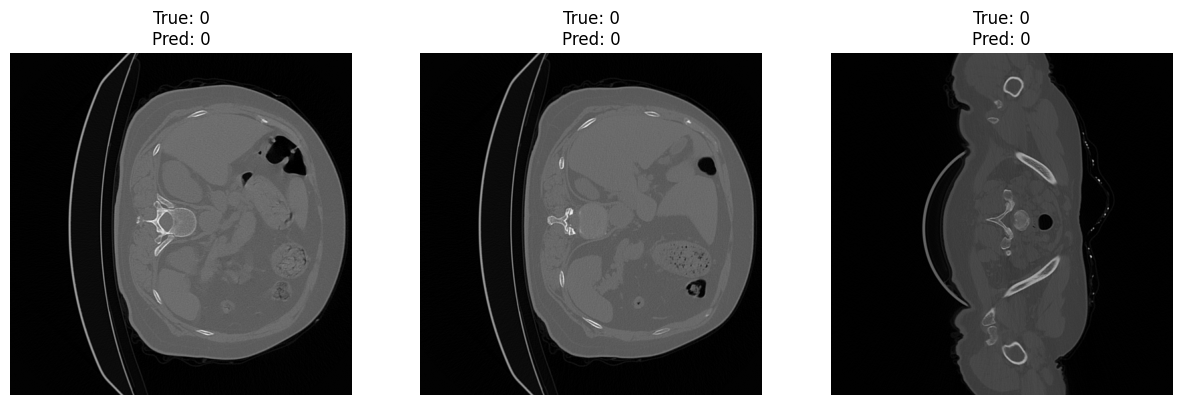

In [24]:
def plot_predictions(model, ct_volume, slice_indices, labels, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, idx in enumerate(slice_indices[:num_samples]):
        slice_data = ct_volume[:, :, idx]
        slice_tensor = torch.tensor(slice_data).unsqueeze(0).unsqueeze(0).float().to(device)
        prediction = model(slice_tensor).squeeze().item()
        axes[i].imshow(slice_data, cmap='gray')
        axes[i].set_title(f"True: {labels[i]}\nPred: {round(prediction)}")
        axes[i].axis('off')
    plt.show()

# Plot first 3 test slices
test_slice_indices = X_test[:3]
test_slice_labels = y_test[:3]
plot_predictions(model, ct_volume, test_slice_indices, test_slice_labels)

In [1]:
import os
import cv2  
import pydicom
import numpy as np
import torch
from tqdm import tqdm

# Set the path to your root folder containing DICOM slices (and subfolders)
root_folder = "C:\\Users\\BAPS\\Documents\\Dicom Analaysis\\Dicom_Dataset\\Single Sliced Dataset\\CMB-MML\\MSB-00140"

# Make sure your model is in evaluation mode
model.eval()

# List to store slices that are predicted to be anomalous
anomalies = []

# Gather all file paths from the folder and its subdirectories
all_file_paths = []
for root, dirs, files in os.walk(root_folder):
    for file in files:
        all_file_paths.append(os.path.join(root, file))

# Create a single progress bar for all files
progress_bar = tqdm(all_file_paths, desc="Processing DICOM slices", ncols=100)

for file_path in progress_bar:
    # Try reading the file as a DICOM; if it fails, skip it.
    try:
        dicom_data = pydicom.dcmread(file_path)
    except Exception:
        continue

    # Get the pixel array from the DICOM and convert to float32
    ct_slice = dicom_data.pixel_array.astype(np.float32)
    
    # Resize the image to 512x512 (to match your model's expected input size)
    ct_slice_resized = cv2.resize(ct_slice, (512, 512))
    
    # Normalize the slice to [0, 1]
    ct_slice_resized = (ct_slice_resized - np.min(ct_slice_resized)) / (np.max(ct_slice_resized) - np.min(ct_slice_resized) + 1e-8)
    
    # Convert the resized slice to a PyTorch tensor and add batch & channel dimensions
    # Expected shape: [batch_size, channels, height, width] -> [1, 1, 512, 512]
    ct_tensor = torch.tensor(ct_slice_resized).unsqueeze(0).unsqueeze(0).to(device)
    
    # Run model inference
    with torch.no_grad():
        output = model(ct_tensor).squeeze()  # Get the predicted probability
    probability = output.item()
    prediction = 1 if probability > 0.5 else 0  # Apply threshold
    
    # Update the progress bar with the latest file's info instead of printing a new line
    progress_bar.set_postfix_str(f"File: {os.path.basename(file_path)} | Pred: {prediction} | Prob: {probability:.4f}")
    
    # Save details if an anomaly is detected
    if prediction == 1:
        anomalies.append((file_path, probability))

# Print a summary of slices with potential anomalies
print("\nAnomalies detected in the following slices:")
if anomalies:
    for path, prob in anomalies:
        print(f"{path} - Probability: {prob:.4f}")
else:
    print("No anomalies detected in the provided folder and its subfolders.")


NameError: name 'model' is not defined